# 8.2 딥드림
- **딥드림**(DeepDream) : 합성곱 신경망이 학습한 표현을 사용하여 이미지를 조작하는 기법
- 컨브넷 필터 시각화 기법과 비슷함
    - 특정 필터가 아닌 전체 층의 활성화를 최대화
    - 빈 이미지나 노이즈가 조금 있는 입력이 아닌 이미 가지고 있는 이미지를 사용함
    - 입력 이미지는 시각 품질을 높이기 위해 여러 다른 스케일(**옥타브**(octave), 이미지 크기를 일정한 비율로 연속적으로 줄이거나 늘리는 방식)로 처리

## 8.2.1 케라스 딥드림 구현
- ImageNet에서 훈련한 컨브넷으로 시작
    - VGG16, VGG19, Xception, ResNet50 등 어떤 컨브넷을 선택했느냐에 따라 시각화에 영향을 미침
    - 딥드림에서 사용한 컨브넷은 인셉션 모델

In [1]:
import tensorflow as tf

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K

# 모델을 훈련하지 않음(모든 훈련 연산 비활성화)
K.set_learning_phase(0)

# 인셉션 V3 네트워크
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

C:\Users\master\anaconda3\envs\multi\lib\site-packages\keras\backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


### 딥드림 설정하기

In [3]:
# 층 이름과 계수를 매핑한 딕셔너리로 최대화하려는 손실에 층의 활성화가 기여할 양을 정함
layer_contributions = {
    'mixed2' : 0.2,
    'mixed3' : 3.,
    'mixed4' : 2.,
    'mixed5' : 1.5,
}

### 최대화할 손실 정의하기
- 경사 상승법으로 손실을 최대화함(모든 필터 활성화를 동시에 최대화)
- 상위 층에 있는 활성화의 L2 노름에 대한 가중치 합을 최대화(어떤 층을 선택했는지에 따라 시각 요소에 큰 영향을 미침)

In [4]:
# 층 이름과 층 객체를 매핑한 딕셔너리
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# 손실을 정의하고 각 층의 기여 분을 이 스칼라 변수에 추가
loss = K.variable(0.)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output # 층의 출력
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    
    # 층 특성의 L2 노름 제곱을 손실에 추가, 이미지 테두리 제외
    loss = loss + coeff * K.sum(K.square(activation[:, 2:-2, 2:-2, :])) / scaling

### 경사 상승법 과정

In [5]:
# 생성된 딥드림 이미지를 저장
dream = model.input

# 손실에 대한 딥드림 이미지의 그래디언트 계산
grads = K.gradients(loss, dream)[0]

# 그래디언트 정규화(중요)
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# 주어진 입력 이미지에서 손실과 그래디언트 값을 계산할 function 객체 생성
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 경사 상승법을 여러 번 반복하여 수행
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print(' ... ', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

### 유틸리티 함수

In [6]:
import scipy
from tensorflow.keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)
    
# 사진을 열고 크기를 줄이고 인셉션V3가 인식하는 텐서 포맷으로 변환
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

# 넘파이 배열을 적절한 이미지 포맷으로 변환
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    
    # inception_v3.preprocess_input 함수에서 수행한 전처리 과정을 복원
    x /= 2.
    x += 0.5
    x *= 255
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### 연속적인 스케일에 걸쳐 경사 상승법 실행하기
- 이미지를 처리하기 위한 스케일(옥타브) 리스트 정의 : 이전 스케일보다 1.4배 큼(작은 이미지로 시작하여 크기를 키움)
    - 가장 작은 것에서 가장 큰 스케일까지 연속적인 각 단계에서 정의한 손실이 최대화되도록 경사 상승법 수행
    - 350x350 크기의 원본 이미지를 178x178 크기로 줄인 뒤 40% 늘려 250x250, 350x350 총 세 번 딥드림 수행
- 스케일을 연속적으로 증가시키면 점점 뭉개지거나 픽셀 경계가 나타나므로 이미지 상세를 많이 잃지 않도록 함
    - 스케일을 늘린 후 이미지에 손실된 디테일을 재주입
    - 작은 이미지 크기 S와 큰 이미지 크기 L이 주어지면 원본 이미지와 각 크기로 변경된 이미지 사이의 차이를 계산

In [7]:
import numpy as np

# 하이퍼파라미터를 바꿀 때마다 새로운 효과가 만들어짐
step = 0.01 # 경사 상승법 단계 크기
num_octave = 3 # 경사 상승법을 실행할 스케일 단계 횟수
octave_scale = 1.4 # 스케일 간의 크기 비율
iterations = 20 # 스케일 단계마다 수행할 경사 상승법 횟수

max_loss = 10. # 손실이 10보다 커지면 이상한 그림이 되는 것을 피하기 위해 경사 상승법 과정을 중지

base_image_path = '../datasets/original_photo_deep_dream.jpg'

img = preprocess_image(base_image_path) # 기본 이미지를 넘파이 배열로 로드

original_shape = img.shape[1:3]
successive_shapes = [original_shape]

# 경사 상승법을 실행할 스케일 크기를 정의한 튜플의 리스트(가장 큰 원본 이미지 크기에서 1.4로 연속적으로 나눔)
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i))
    for dim in original_shape])
    successive_shapes.append(shape)
    
successive_shapes = successive_shapes[::-1] # 크기 순으로 뒤집음

# 이미지의 넘파이 배열을 가장 작은 스케일로 변경
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    # 딥드림 이미지의 스케일을 키움
    img = resize_img(img, shape)
    
    # 경사 상승법을 실행하고 이미지를 변경
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    
    # 작게 줄인 원본 이미지의 스케일을 높임
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    
    # 이 크기에 해당하는 원본 이미지의 고해상도 버전 계산
    same_size_original = resize_img(original_img, shape)
    
    # 두 이미지의 차이 = 스케일을 높였을 때 손실된 디테일
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    # 손실된 디테일을 딥드림 이미지에 다시 주입
    img += lost_detail
    
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='../datasets/dream_at_scale_' + str(shape) + '.png')
    
save_img(img, fname='../datasets/final_dream.png')

처리할 이미지 크기 (178, 178)
 ...  0 번째 손실 : 0.6596663
 ...  1 번째 손실 : 1.0178877
 ...  2 번째 손실 : 1.4632586
 ...  3 번째 손실 : 1.9754055
 ...  4 번째 손실 : 2.5848851
 ...  5 번째 손실 : 3.0875783
 ...  6 번째 손실 : 3.5893693
 ...  7 번째 손실 : 4.0476885
 ...  8 번째 손실 : 4.56241
 ...  9 번째 손실 : 4.953322
 ...  10 번째 손실 : 5.3216953
 ...  11 번째 손실 : 5.8414073
 ...  12 번째 손실 : 6.215662
 ...  13 번째 손실 : 6.63974
 ...  14 번째 손실 : 7.02768
 ...  15 번째 손실 : 7.3992586
 ...  16 번째 손실 : 7.834075
 ...  17 번째 손실 : 8.169078
 ...  18 번째 손실 : 8.496613
 ...  19 번째 손실 : 8.87267
처리할 이미지 크기 (250, 250)
 ...  0 번째 손실 : 2.3133202
 ...  1 번째 손실 : 3.70112
 ...  2 번째 손실 : 4.774913
 ...  3 번째 손실 : 5.771579
 ...  4 번째 손실 : 6.616159
 ...  5 번째 손실 : 7.4136577
 ...  6 번째 손실 : 8.035638
 ...  7 번째 손실 : 8.709481
 ...  8 번째 손실 : 9.364618
처리할 이미지 크기 (350, 350)
 ...  0 번째 손실 : 2.3462133
 ...  1 번째 손실 : 3.4905782
 ...  2 번째 손실 : 4.5353184
 ...  3 번째 손실 : 5.4948044
 ...  4 번째 손실 : 6.372644
 ...  5 번째 손실 : 7.284706
 ...  6 번째 손실 : 8.153193
 ...  7 번째 손

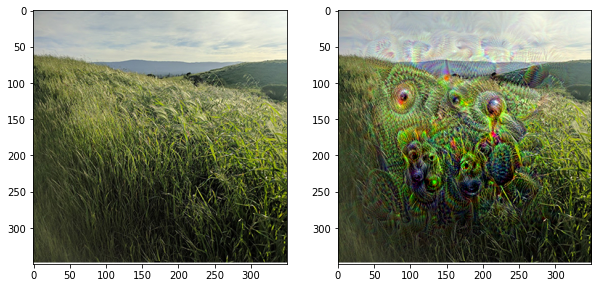

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(deprocess_image(original_img))

plt.subplot(1, 2, 2)
plt.imshow(deprocess_image(img))

plt.show()